### Install

In [11]:
%pip install librosa numpy scipy
%pip install tdqm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import 

In [81]:
import numpy as np
import librosa
import scipy.stats
import os
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

### Compute features

In [46]:
def extract_features(mfccs):
    # Compute statistical features from MFCCs
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_var = np.var(mfccs, axis=1)
    mfccs_max = np.max(mfccs, axis=1)
    mfccs_min = np.min(mfccs, axis=1)
    mfccs_skew = scipy.stats.skew(mfccs, axis=1)
    mfccs_kurtosis = scipy.stats.kurtosis(mfccs, axis=1)

    # Delta and Delta-Delta Features
    mfccs_delta_mean = np.mean(librosa.feature.delta(mfccs))
    mfccs_delta_delta_mean = np.mean(librosa.feature.delta(mfccs, order=2))

    # Other audio features
    spectral_centroids_mean = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_rolloff_mean = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zero_crossing_rate_mean = np.mean(librosa.feature.zero_crossing_rate(y))

    # Combine all features into one vector
    features = {
        'mfccs_mean_0': mfccs_mean[0],
        'mfccs_var_0': mfccs_var[0],
        'mfccs_max_0': mfccs_max[0],
        'mfccs_min_0': mfccs_min[0],
        'mfccs_skew_0': mfccs_skew[0],
        'mfccs_kurtosis_0': mfccs_kurtosis[0],
        'mfccs_mean_1': mfccs_mean[1],
        'mfccs_var_1': mfccs_var[1],
        'mfccs_max_1': mfccs_max[1],
        'mfccs_min_1': mfccs_min[1],
        'mfccs_skew_1': mfccs_skew[1],
        'mfccs_kurtosis_1': mfccs_kurtosis[1],
        'mfccs_mean_2': mfccs_mean[2],
        'mfccs_var_2': mfccs_var[2],
        'mfccs_max_2': mfccs_max[2],
        'mfccs_min_2': mfccs_min[2],
        'mfccs_skew_2': mfccs_skew[2],
        'mfccs_kurtosis_2': mfccs_kurtosis[2],
        'mfccs_delta_mean': mfccs_delta_mean,
        'mfccs_delta_delta_mean': mfccs_delta_delta_mean,
        'spectral_centroids_mean': spectral_centroids_mean,
        'spectral_rolloff_mean': spectral_rolloff_mean,
        'zero_crossing_rate_mean': zero_crossing_rate_mean
    }

    return features

# Read the csv file containing the filenames and ratings
df_source = pd.read_csv('./data-csv/tchatche_split_x.csv')

# Define the directory path
dir_path = './raw-audio'

# Get a list of all .wav files in the directory
wav_files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]

# all_features
all_features = []

# Loop through the list of .wav files and compute features from MFCC for each file
for i, row in tqdm(df_source.iterrows()):

    # Read each wav file
    y, sr = librosa.load(os.path.join(dir_path, row['file_name']))

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=3)

    # Extract features from MFCCs
    features = extract_features(mfccs)

    # Append features to list
    line = {'file_name': row['file_name'], 'rating': row['rating'], **features}
    all_features.append(line)

df = pd.DataFrame(all_features)
df.head(2)

145it [00:27,  5.25it/s]


,file_name,rating,mfccs_mean_0,mfccs_var_0,mfccs_max_0,mfccs_min_0,mfccs_skew_0,mfccs_kurtosis_0,mfccs_mean_1,mfccs_var_1,...,mfccs_var_2,mfccs_max_2,mfccs_min_2,mfccs_skew_2,mfccs_kurtosis_2,mfccs_delta_mean,mfccs_delta_delta_mean,spectral_centroids_mean,spectral_rolloff_mean,zero_crossing_rate_mean
0,QG_20230404144514_1_1071010_1342160_1283_32095...,7,-277.478333,3024.362793,-116.984001,-451.086212,-0.494316,0.208254,72.986671,2029.064941,...,1227.405029,64.400505,-137.166168,0.111702,0.195283,0.006625,-0.014966,2544.947515,4687.358042,0.140449
1,QG_20230404144514_1_1071010_1342160_39370_4386...,8,-294.481384,7088.327148,-159.698898,-452.153778,-0.337327,-1.147493,83.264183,1618.675415,...,1205.549927,44.503937,-120.511093,0.011084,-0.281230,-0.054021,-0.107666,2454.254980,4727.592547,0.133374


### Display features correlation

rating                     1.000000
mfccs_mean_0               0.231563
mfccs_var_0                0.010918
mfccs_max_0                0.137247
mfccs_min_0                0.120010
mfccs_skew_0              -0.071247
mfccs_kurtosis_0           0.016891
mfccs_mean_1               0.107566
mfccs_var_1               -0.137998
mfccs_max_1               -0.045097
mfccs_min_1                0.015683
mfccs_skew_1              -0.143385
mfccs_kurtosis_1           0.185351
mfccs_mean_2              -0.097616
mfccs_var_2                0.005077
mfccs_max_2               -0.149877
mfccs_min_2                0.043575
mfccs_skew_2               0.002187
mfccs_kurtosis_2          -0.151561
mfccs_delta_mean          -0.041997
mfccs_delta_delta_mean    -0.075607
spectral_centroids_mean   -0.089943
spectral_rolloff_mean     -0.079754
zero_crossing_rate_mean   -0.111996
Name: rating, dtype: float64


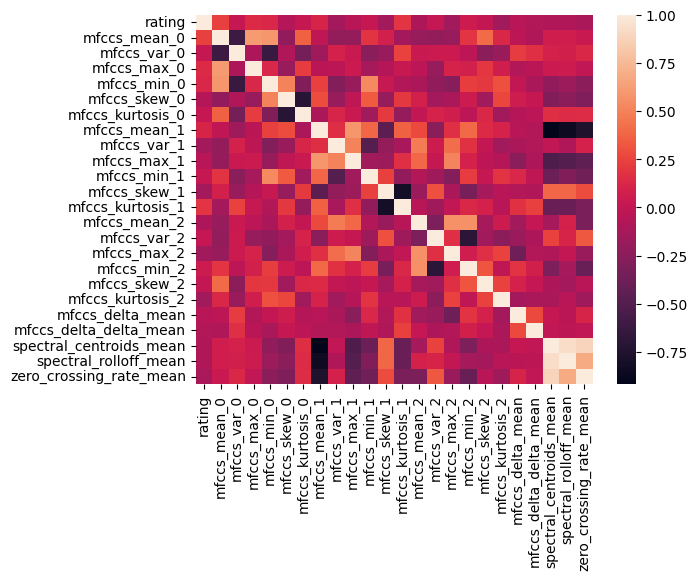

In [48]:
df_num = df.drop(['file_name'], axis=1)
corr = df_num.corr()
sns.heatmap(corr)
print(corr['rating'])

### Train & test

In [103]:
# Get the N most correlated features
nb_features = 10
not_correlated = []
#not_correlated = list(corr['rating'].abs().sort_values(ascending=False)[nb_features+1:].index)
X = df.drop(['file_name', 'rating', *not_correlated], axis=1)

# Remove not correlated features
corr['rating'].abs().sort_values()

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['rating'], test_size=0.2, random_state=42)

# train an XGBoost model on the training set
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'max_depth': 11,
    'eta': 0.05,
    'objective': 'reg:squarederror'
}
model = xgb.train(params, dtrain)

# use the trained model to predict the ratings for the testing set
y_pred = model.predict(dtest)

# evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# evaluate the performance of the model using mean squared error
median = [np.median(y_train) for _ in range(len(y_test))]
mse = mean_squared_error(y_test, median)
print('Mean squared error compared to median:', mse)

Mean squared error: 2.47788043931154
Mean squared error compared to median: 2.793103448275862


In [88]:
# Get features only
X = df.drop(['file_name', 'rating'], axis=1)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['rating'], test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': np.arange(7, 13),
    #'min_child_weight': np.arange(1, 10),
    #'gamma': np.linspace(0, 0.5, 5),
    #'subsample': np.linspace(0.5, 1, 5),
    #'colsample_bytree': np.linspace(0.5, 1, 5),
    'eta': [0.01, 0.05, 0.1, 0.3],
    #'n_estimators': np.arange(100, 1000, 100)
}

# Create a base model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Random search of parameters
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, 
                                n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
xgb_random.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", xgb_random.best_params_)
print("Best Score:", xgb_random.best_score_)

# Predict using the best model
y_pred = xgb_random.best_estimator_.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# evaluate the performance of the model using mean squared error
median = [np.median(y_train) for _ in range(len(y_test))]
mse = mean_squared_error(y_test, median)
print('Mean squared error compared to median:', mse)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/naowak/Thesis/code/tchatche/venv_tchatche/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ..............................eta=0.01, max_depth=7; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=7; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=9; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=9; total time=   0.2s
[CV] END ..............................eta=0.01, max_depth=9; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=7; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=7; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=8; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=8; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=8; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=9; total time=   0.1s
[CV] END ..............................eta=0.01, max_depth=8; total time=   0.1s
[CV] END ...................